In [1]:
import xgboost as xgb 
import pickle
import pandas as pd
import numpy as np
from scipy import stats
import biosppy.signals.ecg as ecg
import matplotlib.pyplot as plt 
import pandas as pd
import math
from scipy.signal import periodogram



In [2]:
def ShortZeroCrossing(ts):
    cnt = 0
    for i in range(len(ts)-1):
        if ts[i] * ts[i+1] < 0:
            cnt += 1
        if ts[i] == 0 and ts[i-1] * ts[i+1] < 0:
            cnt += 1
    return cnt

def LongThresCrossing(ts, thres):
    cnt = 0
    pair_flag = 1
    pre_loc = 0
    width = []
    for i in range(len(ts)-1):
        if (ts[i] - thres) * (ts[i+1] - thres) < 0:
            cnt += 1
            if pair_flag == 1:
                width.append(i-pre_loc)
                pair_flag = 0
            else:
                pair_flag = 1
                pre_loc = i
        if ts[i] == thres and (ts[i-1] - thres) * (ts[i+1] - thres) < 0:
            cnt += 1
    
    if len(width) > 1:
        return [cnt, np.mean(width)]
    else:
        return [cnt, 0.0]

def ShortFeatures(ts,prev_ts):
    #stats
    Range = max(ts) - min(ts)
    Var = np.var(ts)
    Skew = stats.skew(ts)
    Kurtosis = stats.kurtosis(ts)
    Median = np.median(ts)
    ZeroCrossing = ShortZeroCrossing(ts)
    
    # medical features
    T_start = round(0.15 * len(ts))
    T_end = round(0.55 * len(ts))
    P_start = round(0.65 * len(ts))
    P_end = round(0.95 * len(ts))
    
    T_wave = ts[T_start:T_end]
    P_wave = ts[P_start:P_end]
    
    T_peak = max(T_wave)
    P_peak = max(P_wave)
    Q_peak = min(prev_ts[-40:])
    R_peak = ts[0]
    S_peak = min(ts[:40])
    
    T_loc = np.argmax(T_wave)
    P_loc = np.argmax(P_wave)

    #Q_loc = -np.argmin(prev_ts[-40:])
    Q_loc = - 40 + np.argmin(prev_ts[-40:])

    R_loc = 0
    S_loc = np.argmin(ts[:40])

    """if Q_loc <= T_loc:
        Q_loc = len(ts) - 20
        print("exception")"""

    #PR_interval = P_loc - 0
    PR_interval = P_end - P_start

    QRS_duration = S_loc - Q_loc

    #QT_interval = T_loc - Q_loc
    QT_interval = T_end - Q_loc


    QT_corrected = QT_interval / len(ts)

    #TQ_interval = ts[T_loc:Q_loc]
    new_Q_loc = int(0.95*len(ts)) + np.argmin(ts[-1* int(0.05*len(ts)):])
    TQ_interval = ts[T_end:new_Q_loc]

    thres = np.mean(TQ_interval) + (T_peak - np.mean(TQ_interval))/50
    NF, Fwidth = LongThresCrossing(TQ_interval, thres)
    
    RQ_amp = R_peak - Q_peak
    RS_amp = R_peak - S_peak
    ST_amp = T_peak - S_peak
    PQ_amp = P_peak - Q_peak
    QS_amp = Q_peak - S_peak
    RP_amp = R_peak - P_peak
    RT_amp = R_peak - T_peak
    
    #ST_interval = T_loc - S_loc
    ST_interval = T_start - S_loc
    # alternative interval: T_start + T_loc - S_loc

    RS_interval = S_loc - R_loc

    return [Range,Var,Skew,Kurtosis,Median,ZeroCrossing,PR_interval,QRS_duration,QT_interval,QT_corrected,NF,Fwidth,
    RQ_amp,RS_amp,ST_amp,PQ_amp,QS_amp,RP_amp,RT_amp,ST_interval,RS_interval]

def ReducedShortFeatures(ts):
    Range = max(ts) - min(ts)
    Var = np.var(ts)
    Skew = stats.skew(ts)
    Kurtosis = stats.kurtosis(ts)
    Median = np.median(ts)
    ZeroCrossing = ShortZeroCrossing(ts)
    
    # medical features
    T_start = round(0.15 * len(ts))
    T_end = round(0.55 * len(ts))
    P_start = round(0.65 * len(ts))
    P_end = round(0.95 * len(ts))
    
    T_wave = ts[T_start:T_end]
    P_wave = ts[P_start:P_end]
    
    T_peak = max(T_wave)
    P_peak = max(P_wave)
    #Q_peak = min(prev_ts[-40:])
    Q_peak = 0
    R_peak = ts[0]
    S_peak = min(ts[:40])
    
    T_loc = np.argmax(T_wave)
    P_loc = np.argmax(P_wave)

    #Q_loc = -np.argmin(prev_ts[-40:])
    #Q_loc = - 40 + np.argmin(prev_ts[-40:])
    Q_loc = 0

    R_loc = 0
    S_loc = np.argmin(ts[:40])

    """if Q_loc <= T_loc:
        Q_loc = len(ts) - 20
        print("exception")"""

    #PR_interval = P_loc - 0
    PR_interval = P_end - P_start

    QRS_duration = S_loc - Q_loc

    #QT_interval = T_loc - Q_loc
    QT_interval = T_end - Q_loc


    QT_corrected = QT_interval / len(ts)

    #TQ_interval = ts[T_loc:Q_loc]
    new_Q_loc = int(0.95*len(ts)) + np.argmin(ts[-1* int(0.05*len(ts)):])
    TQ_interval = ts[T_end:new_Q_loc]

    thres = np.mean(TQ_interval) + (T_peak - np.mean(TQ_interval))/50
    NF, Fwidth = LongThresCrossing(TQ_interval, thres)
    
    RQ_amp = R_peak - Q_peak
    RS_amp = R_peak - S_peak
    ST_amp = T_peak - S_peak
    PQ_amp = P_peak - Q_peak
    QS_amp = Q_peak - S_peak
    RP_amp = R_peak - P_peak
    RT_amp = R_peak - T_peak
    
    #ST_interval = T_loc - S_loc
    ST_interval = T_start - S_loc
    # alternative interval: T_start + T_loc - S_loc

    RS_interval = S_loc - R_loc


def GetShortFeatures(signal):
    seg = ecg.engzee_segmenter(signal,300, threshold = 0.2)
    r_peaks = seg["rpeaks"]
    ###short_data = ecg.extract_heartbeats(signal, r_peaks, 300)['templates']
    short_data = []
    for i in range(len(r_peaks)-1):
        short_data.append(signal[r_peaks[i]:r_peaks[i+1]])

    num_features = 21
    l = len(short_data[1:])

    results = []

    for i in range(l):
        #print(ShortFeatures(short_data[i+1],short_data[i]))
        #print("ok")
        #print(ShortFeatures(short_data[i+1],short_data[i])[10])
        #return
        results.append( ShortFeatures(short_data[i+1],short_data[i]) )

    if l == 0:
        
        results.append(ReducedShortFeatures(short_data[0]))
        plt.plot(    [ x for x in range(len(short_data[0])) ], short_data[0]    )

    print(len(results))

    total_features = np.stack(results)

    final_features_mean = np.mean(total_features,axis=0)

    features_list =  ["Range", "Var", "Skew", "Kurtosis", "Median", "ZeroCrossing", "PR_interval", "QRS_duration",
     "QT_interval", "QT_corrected", "TQ_interval", "RQ_amp", "RS_amp", "ST_amp", "PQ_amp", "QS_amp", "RP_amp", "RT_amp", "ST_interval", "RS_interval"]

    return final_features_mean,features_list

In [40]:
l1 = [1,2,3]
l2 = [4,5,6]

npy = np.stack([l1,l2])
print(type(npy),npy)

print(np.mean(npy,axis=0))



<class 'numpy.ndarray'> [[1 2 3]
 [4 5 6]]
[2.5 3.5 4.5]


In [3]:
def GetLongFeatures(ts):
    feature_list = []
    row = []
    row.extend(LongBasicStat(ts,feature_list))
    row.extend(LongZeroCrossing(ts,0,feature_list))
    row.extend(LongFFTBandPower(ts,feature_list))
    row.extend(LongFFTPower(ts,feature_list))
    row.extend(LongFFTBandPowerShannonEntropy(ts,feature_list))
    row.extend(LongSNR(ts,feature_list))
    return row, feature_list


def WaveletStat(ts,feature_list):
    '''
    Statistic features for DWT
    '''
    DWTfeat = []
    feature_list.extend(['WaveletStat_'+str(i) for i in range(48)])
    if len(ts) >= 1664:
        db7 = pywt.Wavelet('db7')      
        cAcD = pywt.wavedec(ts, db7, level = 7)
        for i in range(8):
            DWTfeat = DWTfeat + [max(cAcD[i]), min(cAcD[i]), np.mean(cAcD[i]),
                                    np.median(cAcD[i]), np.std(cAcD[i])]
            energy = 0
            for j in range(len(cAcD[i])):
                energy = energy + cAcD[i][j] ** 2
            DWTfeat.append(energy/len(ts))
        return DWTfeat
    else:
        return [0.0]*48
    
def LongBasicStat(ts,feature_list):

    '''
    TODO: 
    
    1. why too much features will decrease F1
    2. how about add them and feature filter before xgb
    
    '''
    Range = max(ts) - min(ts)
    Var = np.var(ts)
    Skew = stats.skew(ts)
    Kurtosis = stats.kurtosis(ts)
    Median = np.median(ts)
#    p_001 = np.percentile(ts, 0.01)
#    p_002 = np.percentile(ts, 0.02)
#    p_005 = np.percentile(ts, 0.05)
#    p_01 = np.percentile(ts, 0.1)
#    p_02 = np.percentile(ts, 0.2)
#    p_05 = np.percentile(ts, 0.5)
    p_1 = np.percentile(ts, 1)
#    p_2 = np.percentile(ts, 2)
    p_5 = np.percentile(ts, 5)
    p_10 = np.percentile(ts, 10)
    p_25 = np.percentile(ts, 25)
    p_75 = np.percentile(ts, 75)
    p_90 = np.percentile(ts, 90)
    p_95 = np.percentile(ts, 95)
#    p_98 = np.percentile(ts, 98)
    p_99 = np.percentile(ts, 99)
#    p_995 = np.percentile(ts, 99.5)
#    p_998 = np.percentile(ts, 99.8)
#    p_999 = np.percentile(ts, 99.9)
#    p_9995 = np.percentile(ts, 99.95)
#    p_9998 = np.percentile(ts, 99.98)
#    p_9999 = np.percentile(ts, 99.99)

    range_99_1 = p_99 - p_1
    range_95_5 = p_95 - p_5
    range_90_10 = p_90 - p_10
    range_75_25 = p_75 - p_25
    
#    return [Range, Var, Skew, Kurtosis, Median]

#    return [Range, Var, Skew, Kurtosis, Median, 
#            p_1, p_5, p_95, p_99]
    
    feature_list.extend(['LongBasicStat_Range', 
                         'LongBasicStat_Var', 
                        'LongBasicStat_Skew', 
                        'LongBasicStat_Kurtosis', 
                        'LongBasicStat_Median', 
                        'LongBasicStat_p_1', 
                        'LongBasicStat_p_5', 
                        'LongBasicStat_p_95', 
                        'LongBasicStat_p_99', 
                        'LongBasicStat_p_10', 
                        'LongBasicStat_p_25', 
                        'LongBasicStat_p_75', 
                        'LongBasicStat_p_90', 
                        'LongBasicStat_range_99_1', 
                        'LongBasicStat_range_95_5', 
                        'LongBasicStat_range_90_10', 
                        'LongBasicStat_range_75_25'])
    return [Range, Var, Skew, Kurtosis, Median, 
            p_1, p_5, p_95, p_99, 
            p_10, p_25, p_75, p_90, 
            range_99_1, range_95_5, range_90_10, range_75_25]

def LongZeroCrossing(ts, thres,feature_list):
    cnt = 0
    for i in range(len(ts)-1):
        if (ts[i] - thres) * (ts[i+1] - thres) < 0:
            cnt += 1
        if ts[i] == thres and (ts[i-1] - thres) * (ts[i+1] - thres) < 0:
            cnt += 1
    feature_list.extend(['LongZeroCrossing_cnt'])
    return [cnt]
    
def LongFFTBandPower(ts,feature_list):
    '''
    return list of power of each freq band
    
    TODO: different band cut method
    '''
    fs = 300
    nfft = len(ts)
    partition = [0, 1.5, 4, 8, 20, 100, fs/2]
    f, psd = periodogram(ts, fs)
    partition = [int(x * nfft / fs) for x in partition]
    p = [sum(psd[partition[x] : partition[x + 1]]) for x in range(len(partition)-1)]
    
    feature_list.extend(['LongFFTBandPower_'+str(i) for i in range(len(p))])

    return p

def LongFFTPower(ts,feature_list):
    '''
    return power
    
    no effect
    '''
    psd = periodogram(ts, fs=300.0, nfft=4500)
    power = np.sum(psd[1])
    feature_list.extend(['LongFFTPower_power'])
    return [power]

def LongFFTBandPowerShannonEntropy(ts,feature_list):
    '''
    return entropy of power of each freq band
    refer to scipy.signal.periodogram
    
    TODO: different band cut method
    '''
    fs = 300
    nfft = len(ts)
    partition = [0, 1.5, 4, 8, 20, 100, fs/2]
    f, psd = periodogram(ts, fs)
    partition = [int(x * nfft / fs) for x in partition]
    p = [sum(psd[partition[x] : partition[x + 1]]) for x in range(len(partition)-1)]
    prob = [x / sum(p) for x in p]
    entropy = sum([- x * math.log(x) for x in prob])
    feature_list.extend(['LongFFTBandPowerShannonEntropy_entropy'])
    return [entropy]

def LongSNR(ts,feature_list):

    '''
    TODO
    '''
    psd = periodogram(ts, fs=300.0)

    signal_power = 0
    noise_power = 0
    for i in range(len(psd[0])):
        if psd[0][i] < 5:
            signal_power += psd[1][i]
        else:
            noise_power += psd[1][i]
          
    feature_list.extend(['LongSNR_snr'])
      
    return [signal_power / noise_power]





In [4]:
#file_path = "few_long_data.pkl"
#with open(file_path,"rb") as file:
    #loaded_data = pickle.load(file)


#data = pd.read_csv('AML_project2/X_train.csv', index_col='id')
data = pd.read_csv('X_train.csv', index_col='id')

# k-fold cross validation
l = len(data)
K=10
subsets = []
subset_size = l // K

for i in range(K):
    s = []
    for j in range(subset_size):
        s.append(data.loc[(i*subset_size)+j].dropna().to_numpy(dtype='float32'))
    subsets.append(s)

print(len(subsets),len(subsets[0]),len(subsets[7]))




10 511 511


In [5]:
#labels = pd.read_csv('AML_project2/y_train.csv', index_col='id')
labels = pd.read_csv('y_train.csv', index_col='id')
labels_array = labels['y'].to_numpy()

labels_subsets = []
for i in range(K):
    labels_subsets.append(labels_array[(i*subset_size):((i+1)*subset_size)])


print(len(labels_subsets),len(labels_subsets[0]),len(labels_subsets[7]))
print(labels_subsets[5])

10 511 511
[0 0 2 1 1 0 2 0 2 2 0 2 0 0 0 1 0 2 2 0 0 0 1 0 0 2 0 2 0 0 0 0 0 2 1 0 2
 0 0 2 0 0 2 2 0 0 0 0 0 0 2 3 0 0 0 0 2 0 2 2 0 0 2 2 2 1 2 0 2 0 0 3 3 0
 1 0 0 2 0 2 2 0 0 1 0 0 1 0 0 0 2 0 0 0 2 0 0 2 1 2 0 0 0 2 2 1 0 0 2 0 2
 0 0 0 2 0 0 0 3 2 0 0 0 2 0 2 0 0 0 2 2 0 0 3 2 2 0 0 1 1 0 0 0 0 0 0 2 0
 2 1 0 2 0 0 1 2 0 2 0 0 0 2 0 0 0 0 0 0 2 0 0 0 2 0 2 0 2 0 1 1 0 0 0 0 2
 0 2 0 0 0 2 1 0 2 1 0 0 0 0 0 2 0 0 0 2 0 2 0 0 2 0 2 0 0 0 0 3 0 0 1 2 0
 0 2 0 1 2 0 0 2 1 0 0 0 2 0 0 0 0 0 0 2 0 0 0 1 0 2 2 1 0 1 2 0 2 1 0 1 2
 0 0 2 2 0 0 2 2 2 0 0 0 0 2 0 2 0 1 1 0 3 0 0 2 0 3 2 0 0 0 0 0 2 0 0 0 2
 2 0 1 2 0 2 0 0 2 2 1 0 2 2 0 2 2 0 0 0 0 0 0 0 0 0 2 0 0 2 0 0 0 2 2 1 2
 1 0 2 2 0 0 0 0 2 0 2 0 2 0 2 2 0 2 0 2 0 0 0 0 0 0 2 2 2 0 0 2 0 1 0 0 2
 2 1 0 3 2 0 0 0 0 0 2 0 0 2 1 0 2 0 2 0 0 2 0 3 2 2 0 0 1 0 0 2 0 0 0 0 0
 0 3 2 0 0 0 0 0 0 0 2 2 0 0 1 0 0 0 0 2 0 0 2 0 2 0 0 0 0 0 0 0 0 2 0 0 1
 0 0 2 2 0 2 0 2 0 0 0 0 2 0 2 3 0 1 1 0 0 1 0 2 0 2 0 2 0 0 0 0 0 0 1 0 0
 2 0 0 3 2 0 0

In [10]:
def train_partial(subsets,labels_subsets,K,index):
    X_train = []
    X_test = []
    y_train = []
    y_test = []
    for i in range(K):
        if i==index:
            for j in range(len(subsets[index])):
                #print(i , j)
                short,_ = GetShortFeatures(subsets[index][j])
                long, _ = GetLongFeatures(subsets[index][j])
                X_test.append(list(short) + list(long))
                y_test.append(labels_subsets[index][j])
        else:
            for j in range(len(subsets[i])):
                #print(i , j)
                short,_ = GetShortFeatures(subsets[i][j])
                long, _ = GetLongFeatures(subsets[i][j])
                X_train.append(list(short) + list(long))
                y_train.append(labels_subsets[i][j])
    """
    print(type(X_train), type(y_train))
    print(len(X_train), len(y_train))
    print(len(X_train[0]))
    """

    dtrain = xgb.DMatrix(X_train, label=y_train)

    params = {
        'objective': 'multi:softmax',  # for multi-class classification
        'num_class': 4,               # number of classes
        'max_depth': 3,               # maximum depth of individual trees
        'learning_rate': 0.1,        # learning rate
        'n_estimators': 100,          # number of boosting rounds
    }

    num_boost_round = 100  # Number of boosting rounds
    model = xgb.train(params, dtrain, num_boost_round=num_boost_round)
    dtest = xgb.DMatrix(X_test)

    y_pred = model.predict(dtest)

    count_correct = 0

    for i in range(len(y_pred)):
        if y_pred[i]==y_test[i]:
            count_correct = count_correct +1

    #return count_correct / len(y_pred)
    return y_pred

y = train_partial(subsets,labels_subsets,K,5)

print(type(y))
y


65
35
28
68
44
24
39
41
62
14
25
31
23
37
29
31
17
44
26
12
34
36
29
50
33
26
25
27
28
17
46
34
33
94
41
23
36
27
81
31
53
36
52
29
56
32
47
8
40
83
35
25
27
31
22
17
44
39
30
32
32
25
36
37
53
39
32
30
29
13
34
24
42
41
37
23
34
57
49
43
27
26
54
39
37
11
35
37
30
47
32
30
68
29
27
41
17
55
37
27
91
54
22
13
41
44
63
25
15
68
24
28
41
36
60
24
28
45
21
36
30
39
24
35
25
25
49
39
29
33
27
139
31
38
30
34
36
60
46
29
24
26
28
64
50
45
32
38
26
46
35
29
64
40
38
10
79
64
24
39
33
44
27
35
24
31
36
25
26
26
29
41
36
25
30
30
33
25
33
46
33
34
27
36
60
31
15
50
44
40
29
28
35
31
60
63
43
44
26
11
40
29
64
46
32
28
31
23
35
38
24
36
40
33
28
68
28
27
35
34
17
36
42
94
40
23
25
41
31
28
45
30
33
25
25
110
38
28
51
30
30
32
29
32
45
28
34
25
32
27
43
35
50
26
34
29
62
30
33
24
34
17
26
57
8
32
26
28
19
10
34
43
44
19
27
35
56
36
39
30
45
42
144
33
33
48
26
68
38
30
59
37
45
29
29
22
23
26
36
18
33
26
26
34
52
30
39
37
29
18
44
23
24
23
33
37
28
26
38
25
32
25
28
36
34
30
33
91
30
19
32
35
60


array([0., 0., 2., 1., 1., 0., 0., 0., 0., 2., 2., 2., 0., 0., 0., 0., 0.,
       2., 0., 0., 0., 0., 2., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 2.,
       3., 2., 0., 0., 0., 2., 0., 0., 2., 0., 0., 0., 2., 0., 1., 2., 0.,
       2., 0., 0., 3., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       2., 1., 0., 2., 0., 0., 0., 0., 0., 2., 0., 0., 1., 2., 0., 0., 0.,
       0., 0., 2., 1., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 3.,
       2., 0., 0., 0., 2., 0., 2., 0., 0., 0., 0., 2., 0., 0., 3., 2., 2.,
       0., 0., 0., 1., 2., 0., 0., 0., 0., 0., 2., 0., 2., 1., 2., 0., 0.,
       0., 1., 2., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 2., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 2., 1., 0., 2., 2., 0., 0., 0., 0., 0., 3., 0., 0., 0.,
       0., 0., 0., 0., 0., 2., 0., 2., 0., 0., 0., 2., 0., 0., 0., 1., 2.,
       0., 2., 0., 0., 1.

[ 113  347  806 1063 1250 1680 1894]
[]


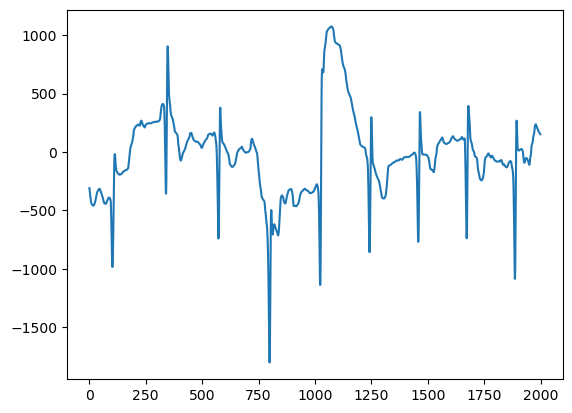

In [48]:
sig = subsets[0][65]
plt.plot([x for x in range(2000)],sig[:2000])
seg = ecg.engzee_segmenter(sig[:2000],300, threshold = 0.2)
r_peaks = seg["rpeaks"]
print(r_peaks)
seg = ecg.engzee_segmenter(sig[:2000],300, threshold = 0.48)
r_peaks = seg["rpeaks"]
print(r_peaks)



In [7]:
def train(subsets,labels_subsets,K):
    results = []
    for i in range(K):
        results.append(train_partial(subsets,labels_subsets,K,i))

    return float(np.mean(results))

train(subsets,labels_subsets,K)

0 0
65
0 1
35
0 2
28
0 3
68
0 4
44
0 5
24
0 6
39
0 7
41
0 8
62
0 9
14
0 10
25
0 11
31
0 12
23
0 13
37
0 14
29
0 15
31
0 16
17
0 17
44
0 18
26
0 19
12
0 20
34
0 21
36
0 22
29
0 23
50
0 24
33
0 25
26
0 26
25
0 27
27
0 28
28
0 29
17
0 30
46
0 31
34
0 32
33
0 33
94
0 34
41
0 35
23
0 36
36
0 37
27
0 38
81
0 39
31
0 40
53
0 41
36
0 42
52
0 43
29
0 44
56
0 45
32
0 46
47
0 47
8
0 48
40
0 49
83
0 50
35
0 51
25
0 52
27
0 53
31
0 54
22
0 55
17
0 56
44
0 57
39
0 58
30
0 59
32
0 60
32
0 61
25
0 62
36
0 63
37
0 64
53
0 65
39
0 66
32
0 67
30
0 68
29
0 69
13
0 70
34
0 71
24
0 72
42
0 73
41
0 74
37
0 75
23
0 76
34
0 77
57
0 78
49
0 79
43
0 80
27
0 81
26
0 82
54
0 83
39
0 84
37
0 85
11
0 86
35
0 87
37
0 88
30
0 89
47
0 90
32
0 91
30
0 92
68
0 93
29
0 94
27
0 95
41
0 96
17
0 97
55
0 98
37
0 99
27
0 100
91
0 101
54
0 102
22
0 103
13
0 104
41
0 105
44
0 106
63
0 107
25
0 108
15
0 109
68
0 110
24
0 111
28
0 112
41
0 113
36
0 114
60
0 115
24
0 116
28
0 117
45
0 118
21
0 119
36
0 120
30
0 121
39
0 122
24
0 12

KeyboardInterrupt: 

In [2]:
import tensorflow as tf
import pickle





122550